## Model Evaluation & Analysis
Here we evaluate the final Decision Tree model, compare it with Random Forest and Categorical NB, and reflect on strengths, limitations, and potential risks.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_curve, auc
import joblib
from sklearn.inspection import permutation_importance

In [40]:
X_train = joblib.load('artifacts/X_train_final.pkl')
X_test = joblib.load('artifacts/X_test_final.pkl')
y_train = joblib.load('artifacts/y_train_encoded.pkl')
y_test = joblib.load('artifacts/y_test_encoded.pkl')
prep_package = joblib.load("artifacts/mushroom_preprocessing_pipeline.pkl")
preprocessor = prep_package["pipeline"]

**Loading all three models**

In [41]:
dt_model = joblib.load("artifacts/Decision Tree.pkl")
rf_model = joblib.load("artifacts/Random Forest.pkl")
nb_model = joblib.load("artifacts/Categorical NB.pkl")

y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_nb = nb_model.predict(X_test)

In [42]:
models = {
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'Categorical NB': nb_model
}

In [43]:
TARGET_NAMES = ['edible', 'poisonous']

**Model Evaluation and Analysis**

In [44]:
print("\n--- Classification Report (Decision Tree) ---")
print(classification_report(y_test, y_pred_dt, target_names=TARGET_NAMES))

print("\n--- Classification Report (Random Forest) ---")
print(classification_report(y_test, y_pred_rf, target_names=TARGET_NAMES))

print("\n--- Classification Report (Categorical NB) ---")
print(classification_report(y_test, y_pred_nb, target_names=TARGET_NAMES))


--- Classification Report (Decision Tree) ---
              precision    recall  f1-score   support

      edible       1.00      1.00      1.00       842
   poisonous       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625


--- Classification Report (Random Forest) ---
              precision    recall  f1-score   support

      edible       1.00      1.00      1.00       842
   poisonous       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625


--- Classification Report (Categorical NB) ---
              precision    recall  f1-score   support

      edible       0.93      0.99      0.96       842
   poisonous       0.99      0.92      0.95       783

    accuracy                           0

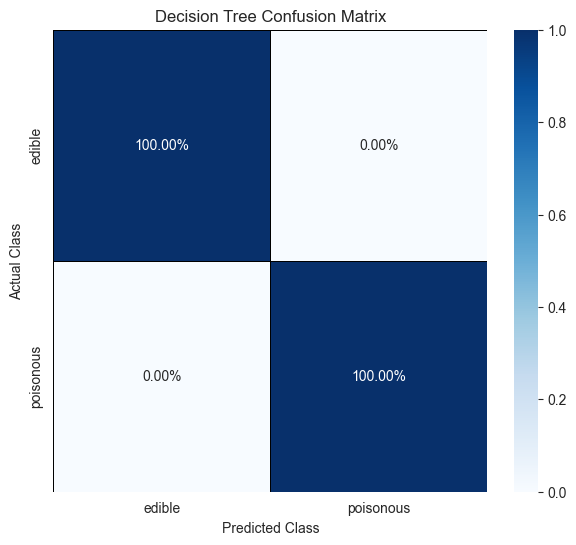

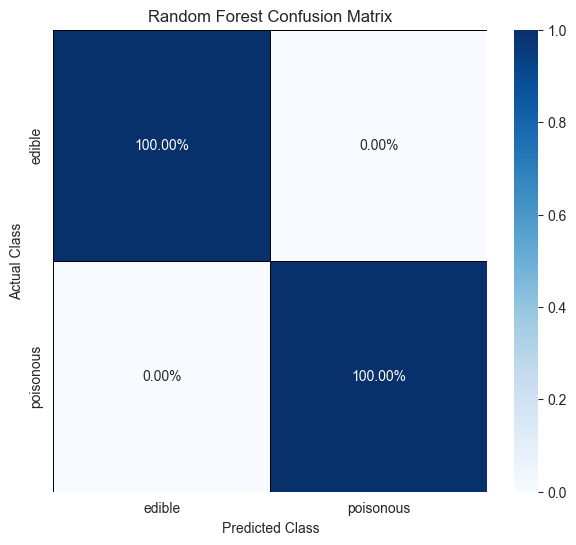

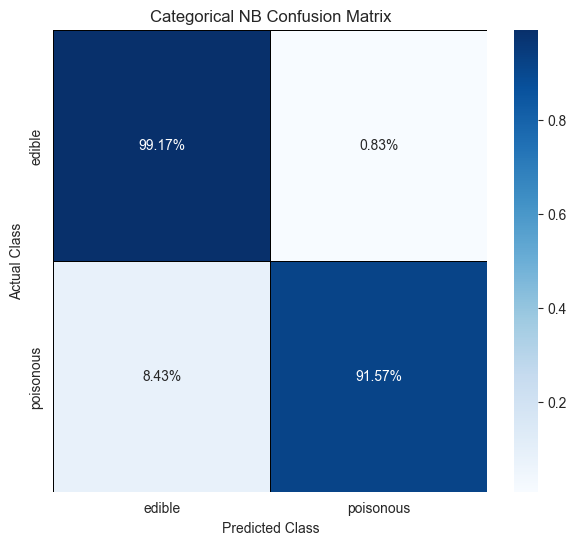

In [45]:
# Display confusion matrix for each model
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=TARGET_NAMES, yticklabels=TARGET_NAMES,
                linewidths=.5, linecolor='black')
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

The confusion matrix shows that Random Forest and Decision Tree models had similar performance with high accuracy across classes, while the Naive Bayes model performed comparatively lower with more misclassifications.

**Validation Curve**

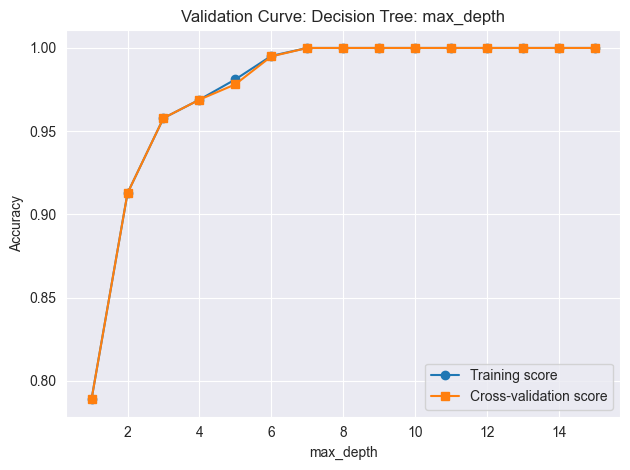

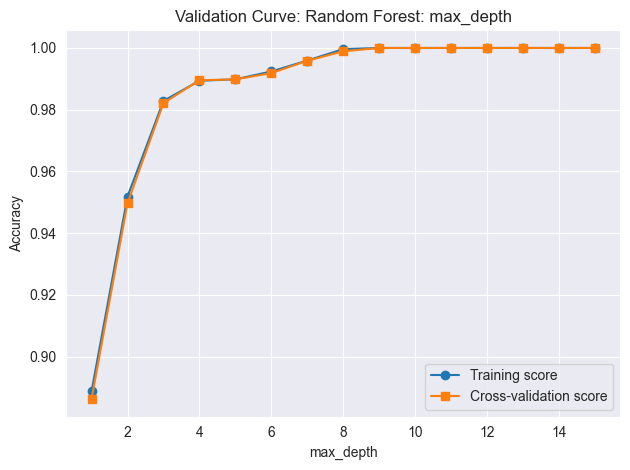

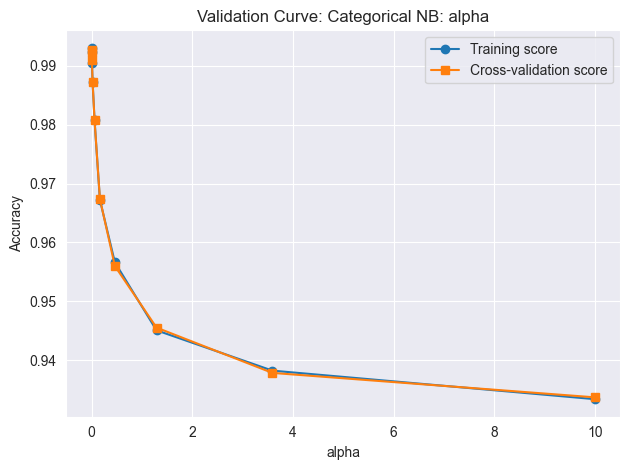

In [46]:
model_params = [
    (DecisionTreeClassifier, "max_depth", np.arange(1, 16), "Decision Tree: max_depth"),
    (RandomForestClassifier, "max_depth", np.arange(1, 16), "Random Forest: max_depth"),
    (CategoricalNB, "alpha", np.logspace(-3, 1, 10), "Categorical NB: alpha"),
]

for model_class, param_name, param_range, title in model_params:
    train_scores, test_scores = validation_curve(
        model_class(random_state=42) if 'random_state' in model_class().get_params() else model_class(),
        X_train, y_train,
        param_name=param_name,
        param_range=param_range,
        cv=5,
        scoring="accuracy"
    )
    plt.plot(param_range, np.mean(train_scores, axis=1), label='Training score', marker='o')
    plt.plot(param_range, np.mean(test_scores, axis=1), label='Cross-validation score', marker='s')
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")
    plt.title(f"Validation Curve: {title}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

The validation curves show that Random Forest and Decision Tree models both reached high accuracy as max_depth increased, with results staying strong at higher values. Naive Bayes, on the other hand, had lower accuracy overall and its results dropped as the alpha value got larger.

**ROC (Reciever Operating Characteristic) Curve**

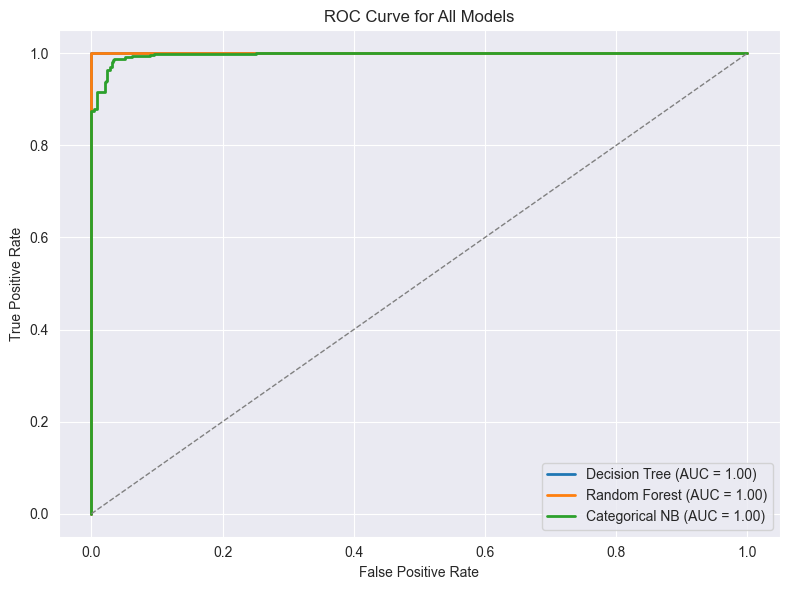

In [47]:
plt.figure(figsize=(8, 6))

for label, model in models.items():
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for All Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

The ROC curve shows that all three models—Decision Tree, Random Forest, and Naive Bayes—achieved very high AUC scores of 1.00, meaning they all performed extremely well at distinguishing between the classes on the test set.

**Feature Importance Plot**

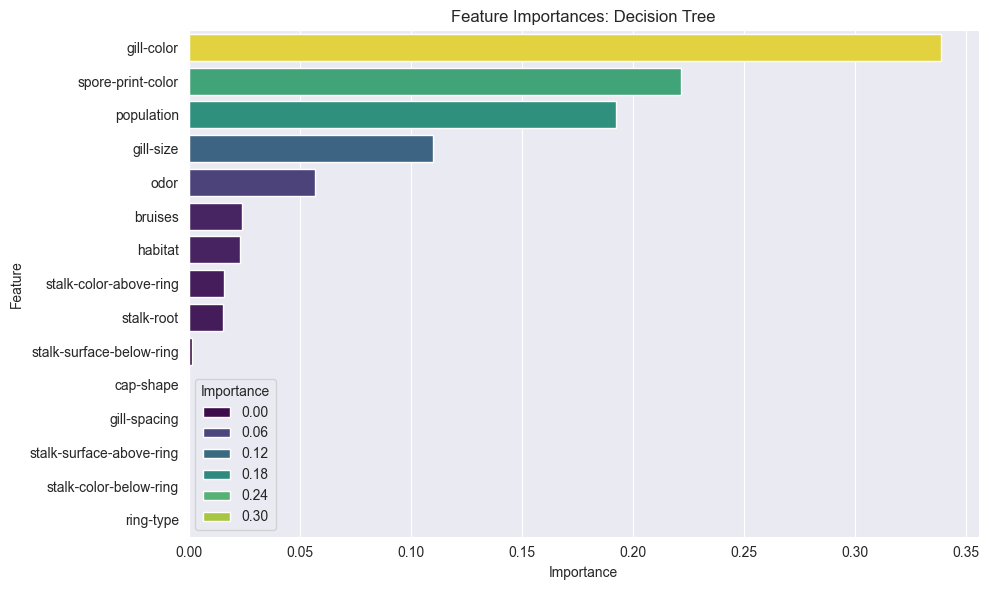

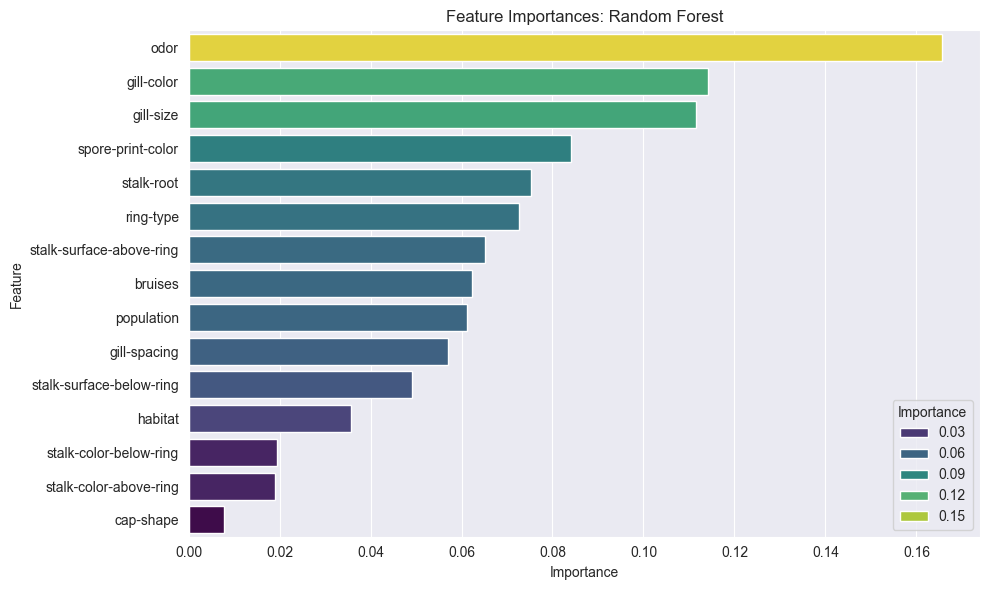

In [48]:
models_ft = {
    'Decision Tree': dt_model,
    'Random Forest': rf_model
}
selected_feature_names = prep_package["selected_feature_names"]

for name, model in models_ft.items():
    importances = model.feature_importances_
    fi_df = pd.DataFrame({
        "Feature": selected_feature_names,
        "Importance": importances
    })
    fi_df = fi_df.sort_values("Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", hue="Importance",  data=fi_df, palette="viridis")
    plt.title(f"Feature Importances: {name}")
    plt.tight_layout()
    plt.show()

The feature importance graphs show that the Decision Tree model relied most on "gill-color," while the Random Forest model found "odor" to be the most important feature. Both models used several features, but focused on different top predictors for classification.

**Permutation Importance for NB**

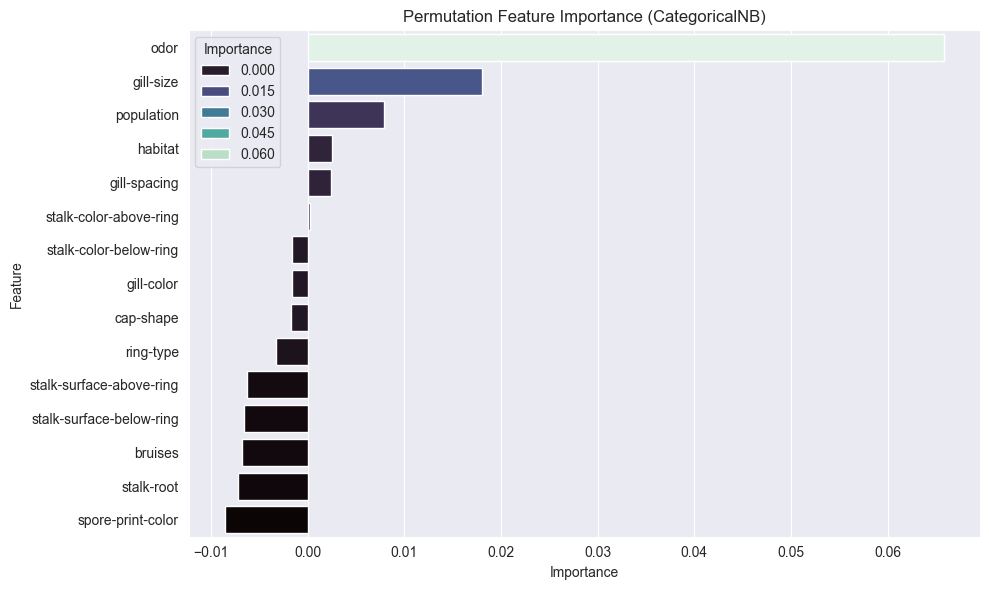

In [49]:
result = permutation_importance(
    nb_model, X_test, y_test,
    n_repeats=10, random_state=0, n_jobs=-1
)

perm_df = pd.DataFrame({
    "Feature": selected_feature_names,
    "Importance": result.importances_mean
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", hue="Importance", data=perm_df, palette="mako")
plt.title("Permutation Feature Importance (CategoricalNB)")
plt.tight_layout()
plt.show()

For the Categorical Naive Bayes model, the feature importance plot shows that "odor" was by far the most important predictor, followed by "gill-size" and "population," while most other features contributed very little to its classifications.

 **1) Decision Tree (DT)**
<br><br> **STRENGTH:** It's the simplest model. Achieved 100% accuracy with clear, transparent rules. Low computing power needed.
<br> **WEAKNESS:** The perfect 100% score suggests the model might be too tuned to this data, risking failure on new, slightly different real-world data.
<br><br> **2) Random Forest (RF)**
<br><br> **STRENGTH:** As a group of trees, it's generally a very stable and dependable model that handles data noise well.
<br> **WEAKNESS:** Does not perform better than the DT, but is harder to explain and uses more computing power. We reject it because it's unnecessarily complicated.
<br><br> **3) Categorical NB**
<br><br> **STRENGTH:** Quickest model to train, making it a good starting point.
<br> **WEAKNESS:** It failed because it assumes features don't influence each other, which is not true for real-world data. Also, its performance is lower than other models have (≈96%). Also, if new feature appears in test data, the model will assign zero probability so we'll need to apply smoothing to ensure that our mushrooms with new ring type are recognized.

**Overall Reflection**
- Cross-validation shows consistent DT performance
- Confusion matrix confirms no misclassifications
- Feature importance highlights key drivers (e.g., 'odor', 'spore-print-color')
- Limitation: perfect accuracy could mask overfitting; monitor real-world deployment
- Fairness & bias: not critical here, but ensure generalizability for new data